<a href="https://colab.research.google.com/github/asnoldy02-cell/sds510/blob/main/Module_3_Essentials_Crime_Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()


Saving Street_Traffic_Volumes.csv to Street_Traffic_Volumes.csv


In [6]:
import os
os.listdir()

['.config', 'Street_Traffic_Volumes.csv', 'sample_data']

In [7]:
import pandas as pd

traffic = pd.read_csv("Street_Traffic_Volumes.csv")
traffic.head()

,X,Y,OBJECTID,ID,IsNTMT,STREET,BLOCKNUM,BLOCKDIR,CROSSSTREET,CROSSBLOCK,...,VOLUME,COUNTTYPE,DIRECTION,DESCRIPTION,DISTRICT,COUNTSTATION,BUDGETYR,COMMENTS,VERIFIEDON,AVG_SPEED
0,646180.302822,8.949711e+05,25947,13780,0,GRAND AVE,1200,N,ROOSEVELT ST,1500,...,6830,MID4,South Bound,Special,4,2420,2016,NaN,2015/09/10 15:08:13+00,37.0
1,646180.302822,8.949711e+05,25948,13780,0,GRAND AVE,1200,N,16TH AVE,1600,...,6971,MID4,South Bound,Special,4,2420,2016,NaN,2015/09/09 22:06:44+00,37.0
2,646226.129265,8.950183e+05,25949,13780,0,GRAND AVE,1200,N,ROOSEVELT ST,1500,...,6298,MID4,North Bound,Special,4,2420,2016,NaN,2015/09/10 15:08:13+00,37.0
3,646226.129265,8.950183e+05,25950,13780,0,GRAND AVE,1200,N,16TH AVE,1600,...,6476,MID4,North Bound,Special,4,2420,2016,NaN,2015/09/09 22:06:44+00,37.0
4,645643.030184,1.012856e+06,25951,13784,1,DOVE VALLEY RD,33000,N,16TH AVE,1580,...,2083,MID2,West Bound,Cut Thru Traffic,2,5483,2016,NaN,2015/09/14 20:16:20+00,46.0


In [15]:
traffic.columns


Index(['X', 'Y', 'OBJECTID', 'ID', 'IsNTMT', 'STREET', 'BLOCKNUM', 'BLOCKDIR',
       'CROSSSTREET', 'CROSSBLOCK', 'CROSSBLOCKDIR', 'COUNTDATE', 'VOLUME',
       'COUNTTYPE', 'DIRECTION', 'DESCRIPTION', 'DISTRICT', 'COUNTSTATION',
       'BUDGETYR', 'COMMENTS', 'VERIFIEDON', 'AVG_SPEED', 'ZIP'],
      dtype='object')

Since there are no ZIPS, we will use address and cross streets to find intersections.

In [22]:
traffic["INTERSECTION"] = (
    traffic["STREET"].astype(str)
    + " "
    + traffic["BLOCKNUM"].astype(str)
    + " & "
    + traffic["CROSSSTREET"].astype(str)
)

traffic_by_intersection = (
    traffic.groupby("INTERSECTION")["VOLUME"]
    .sum()
    .reset_index()
)

We will create a bar graph to show the top 10 high-traffic intersections.

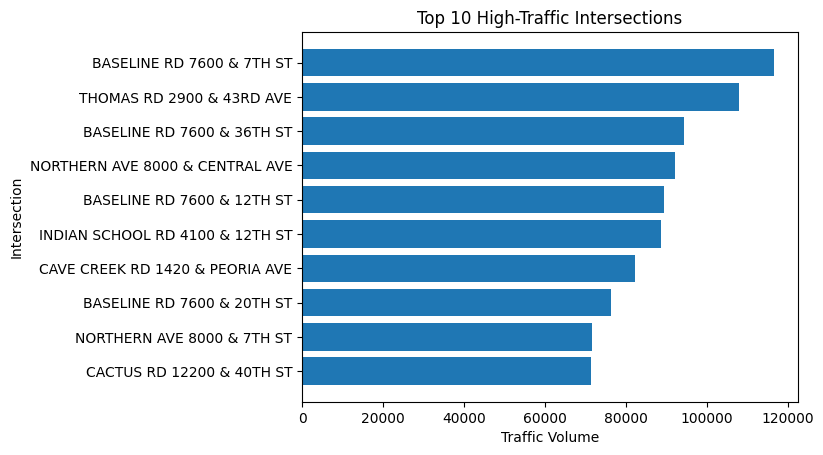

In [26]:
import matplotlib.pyplot as plt

top_traffic = traffic_by_intersection.sort_values("VOLUME", ascending=False).head(10)

plt.barh(top_traffic["INTERSECTION"], top_traffic["VOLUME"])
plt.xlabel("Traffic Volume")
plt.ylabel("Intersection")
plt.title("Top 10 High-Traffic Intersections")
plt.gca().invert_yaxis()
plt.show()

In [32]:
from google.colab import files
uploaded = files.upload()

Saving crime-data_crime-data_crimestat.csv to crime-data_crime-data_crimestat.csv


We will upload the crime-data_crime-data_crimestat.csv to display what kind of crimes happened in on which street and intersection.

In [60]:
import pandas as pd

crime_df = pd.read_csv('crime-data_crime-data_crimestat.csv')
print("Crime data loaded successfully!")
display(crime_df.head())

/tmp/ipython-input-3724495617.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_df = pd.read_csv('crime-data_crime-data_crimestat.csv')


Crime data loaded successfully!


,INC NUMBER,OCCURRED ON,OCCURRED TO,UCR CRIME CATEGORY,100 BLOCK ADDR,ZIP,PREMISE TYPE,GRID
0,201600000594484,11/01/2015 00:00,NaN,RAPE,13XX E ALMERIA RD,85006.0,SINGLE FAMILY HOUSE,BD30
1,201500002102327,11/01/2015 00:00,11/01/2015 09:00,LARCENY-THEFT,51XX N 15TH ST,85014.0,APARTMENT,BJ30
2,201500002168686,11/01/2015 00:00,11/11/2015 09:30,LARCENY-THEFT,14XX E HIGHLAND AVE,85014.0,PARKING LOT,BI30
3,201500002102668,11/01/2015 00:00,11/01/2015 11:50,MOTOR VEHICLE THEFT,69XX W WOOD ST,85043.0,SINGLE FAMILY HOUSE,AF12
4,201600000052855,11/01/2015 00:00,01/09/2016 00:00,MOTOR VEHICLE THEFT,N 43RD AVE & W CACTUS RD,85029.0,SINGLE FAMILY HOUSE,DA19


Here is the code to merge the crime and traffic dataframes:

In [54]:
crime_df = crime_df.rename(columns={'100 BLOCK ADDR': 'INTERSECTION'})

merged = pd.merge(crime_df, traffic_by_intersection, on="INTERSECTION", how="left")

In [45]:
display(merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605275 entries, 0 to 605274
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   INC NUMBER          605275 non-null  object 
 1   OCCURRED ON         604856 non-null  object 
 2   OCCURRED TO         386500 non-null  object 
 3   UCR CRIME CATEGORY  605275 non-null  object 
 4   INTERSECTION        605275 non-null  object 
 5   ZIP                 605266 non-null  float64
 6   PREMISE TYPE        601088 non-null  object 
 7   GRID                603639 non-null  object 
 8   VOLUME              0 non-null       float64
dtypes: float64(2), object(7)
memory usage: 41.6+ MB


None

Now, we aggregate the crime data by intersection to get a count of crimes per intersection.

In [50]:
crime_by_intersection = (
    crime_df.groupby("INTERSECTION").size().reset_index(name="CRIME_COUNT")
)
display(crime_by_intersection.head())

,INTERSECTION,CRIME_COUNT
0,100XX N 11TH AVE,22
1,100XX N 12TH ST,14
2,100XX N 13TH PL,6
3,100XX N 13TH ST,33
4,100XX N 14TH ST,12


Next, we merge the aggregated crime data with the traffic data grouped by intersection.

In [53]:
merged_aggregated_data = pd.merge(
    traffic_by_intersection, crime_by_intersection, on="INTERSECTION", how="left"
)

merged_aggregated_data["CRIME_COUNT"] = merged_aggregated_data["CRIME_COUNT"].fillna(0)

display(merged_aggregated_data.head())

,INTERSECTION,VOLUME,CRIME_COUNT
0,101ST AVE 5000 & CAMELBACK RD,2343,0.0
1,101ST AVE 5450 & CAMELBACK RD,652,0.0
2,103RD AVE 10300 & 105TH AVE,1095,0.0
3,103RD AVE 10300 & MARIPOSA ST,1410,0.0
4,103RD AVE 1850 & DURANGO ST,1986,0.0


Finally, we create the scatter plot using the aggregated and merged data.

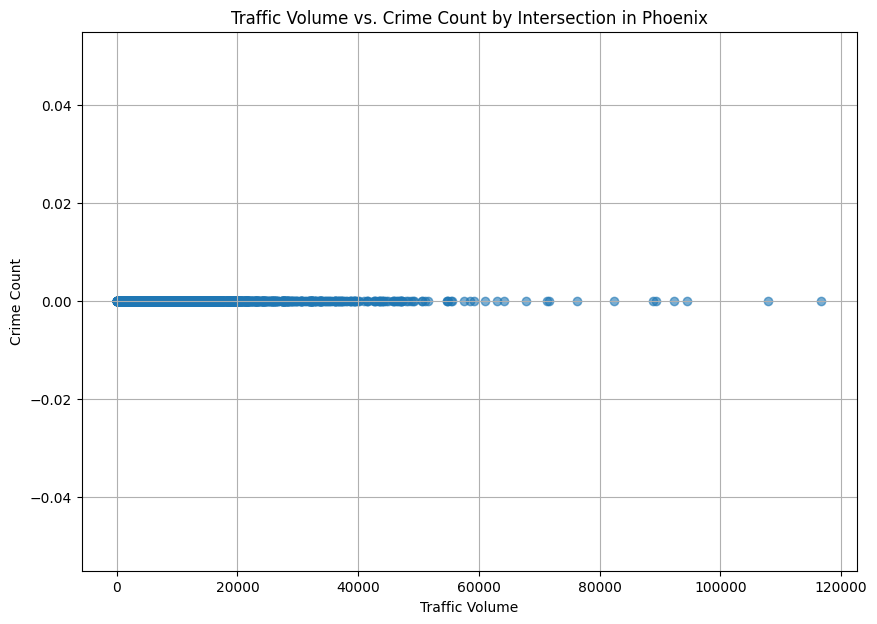

In [52]:
plt.figure(figsize=(10, 7))
plt.scatter(
    merged_aggregated_data["VOLUME"],
    merged_aggregated_data["CRIME_COUNT"],
    alpha=0.6
)

plt.title("Traffic Volume vs. Crime Count by Intersection in Phoenix")
plt.xlabel("Traffic Volume")
plt.ylabel("Crime Count")
plt.grid(True)
plt.show()

We can also compare traffic volume to crime count by intersection since there are no ZIPS provided.

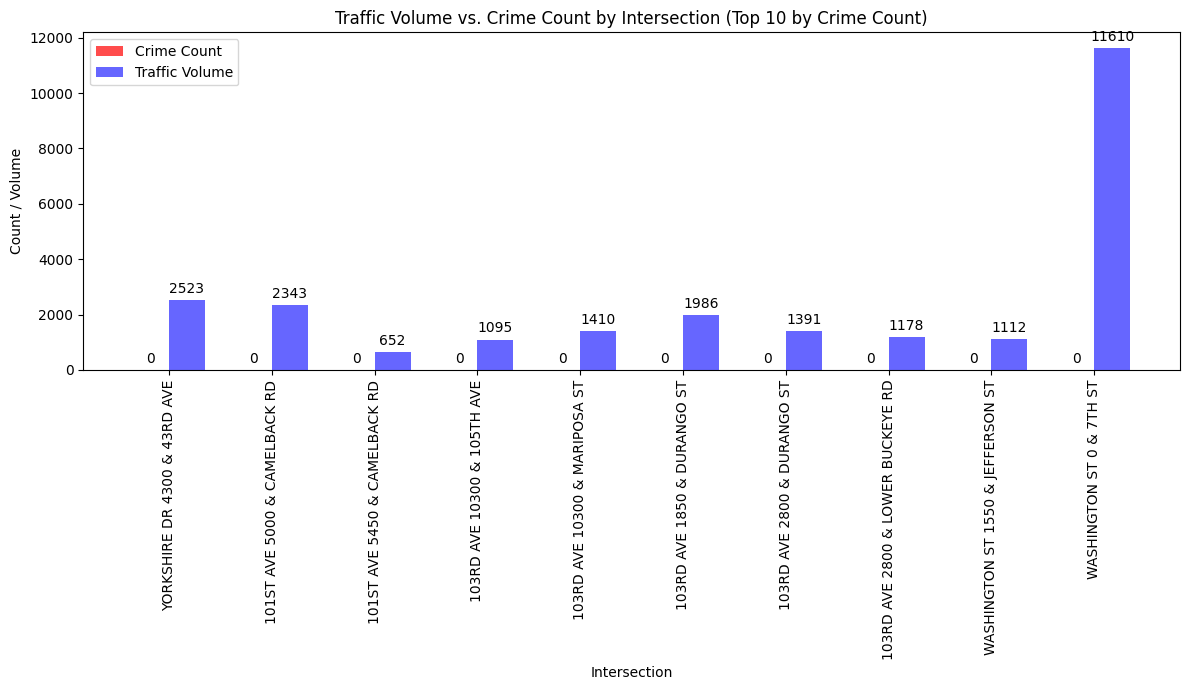

In [59]:
import numpy as np
import matplotlib.pyplot as plt

top10 = merged_aggregated_data.sort_values("CRIME_COUNT", ascending=False).head(10)

x = np.arange(len(top10))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars1 = ax.bar(x - width/2, top10["CRIME_COUNT"], width, label="Crime Count", color="red", alpha=0.7)
bars2 = ax.bar(x + width/2, top10["VOLUME"], width, label="Traffic Volume", color="blue", alpha=0.6)

ax.set_xlabel("Intersection")
ax.set_ylabel("Count / Volume")
ax.set_title("Traffic Volume vs. Crime Count by Intersection (Top 10 by Crime Count)")
ax.set_xticks(x)
ax.set_xticklabels(top10["INTERSECTION"], rotation=90, ha="center")
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)


plt.tight_layout()
plt.show()

In [61]:
merged.to_csv("crime_housing_essentials.csv", index=False)